start test
(32004, 2)
Input map      Subfields (R)    Subfields (p corrected)    A-P gradinet (R)    A-P gradinet (p corrected)  0th most correlated       0th (R)    0th (p corrected)  1th most correlated      1th (R)    1th (p corrected)  2th most correlated      2th (R)    2th (p corrected)
-----------  ---------------  -------------------------  ------------------  ----------------------------  ----------------------  ---------  -------------------  ---------------------  ---------  -------------------  ---------------------  ---------  -------------------
inputMap0           0.428859                      0.006           -0.123928                         0.872  histology-Blockface      0.986204                    0  MRI-7T-thickness        0.509007                    0  MRI-9p4T-PD             0.505217                0.008
inputMap1          -0.371415                      0.074            0.443094                         0.605  histology-Bielschowsky   0.946073                    0 

({'Input map': ['inputMap0', 'inputMap1'],
  'Subfields (R)': array([ 0.42885861, -0.37141487]),
  'Subfields (p corrected)': array([0.006, 0.074]),
  'A-P gradinet (R)': array([-0.12392809,  0.44309376]),
  'A-P gradinet (p corrected)': array([0.872, 0.605]),
  '0th most correlated': array(['histology-Blockface', 'histology-Bielschowsky'], dtype=object),
  '0th (R)': array([0.98620398, 0.94607274]),
  '0th (p corrected)': array([0., 0.]),
  '1th most correlated': array(['MRI-7T-thickness', 'MRI-9p4T-R2star'], dtype=object),
  '1th (R)': array([0.50900733, 0.53471159]),
  '1th (p corrected)': array([0., 0.]),
  '2th most correlated': array(['MRI-9p4T-PD', 'MRI-9p4T-PD'], dtype=object),
  '2th (R)': array([ 0.50521656, -0.49881801]),
  '2th (p corrected)': array([0.008, 0.011])},
 <Axes: xlabel="absolute AP correlation (Pearson's R)", ylabel="absolute subfield correlation (Spearmann's R)">)

CPU times: user 11min 32s, sys: 4min 12s, total: 15min 44s
Wall time: 11min 38s


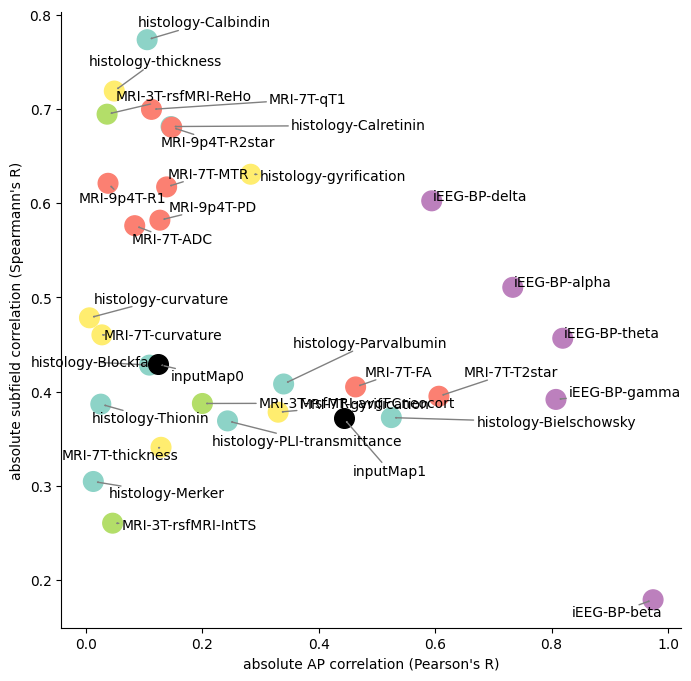

In [ ]:
%%time
import nibabel as nib
import numpy as np
import hippomaps as hm

print("start test")
map1 = nib.load("/Users/enningyang/Downloads/histology-Blockface_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii").darrays[0].data
map2 = nib.load("/Users/enningyang/Downloads/histology-Bieloschowsky_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii").darrays[0].data

map_set = np.stack((map1,map2), axis=1)
print(map_set.shape)
contextualize2D(map_set)

#CPU times: user 11min 32s, sys: 4min 12s, total: 15min 44s
# Wall time: 11min 38s

In [1]:
%%time
import nibabel as nib
import numpy as np
import hippomaps as hm

print("start test")
map1 = nib.load("/Users/enningyang/Downloads/histology-Blockface_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii").darrays[0].data
map2 = nib.load("/Users/enningyang/Downloads/histology-Bieloschowsky_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii").darrays[0].data

map_set = np.stack((map1,map2), axis=1)
print(map_set.shape)
# contextualize2D(map_set)

#CPU times: user 11min 32s, sys: 4min 12s, total: 15min 44s
# Wall time: 11min 38s

start test
(32004, 2)
CPU times: user 2.32 s, sys: 1.97 s, total: 4.28 s
Wall time: 15.2 s


In [2]:
import numpy as np
import nibabel as nib
import pandas as pd
from tabulate import tabulate
from scipy.ndimage import rotate, shift
from scipy.stats import spearmanr, pearsonr
from joblib import Parallel, delayed
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
import warnings
import hippomaps.utils
import hippomaps.config
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from adjustText import adjust_text
from brainspace.mesh.mesh_io import read_surface
from hippomaps.moran import MoranRandomization
from brainspace.mesh import mesh_elements as me
from eigenstrapping import SurfaceEigenstrapping
from pathlib import Path
resourcesdir= './resources'


def spin_test(imgfix, imgperm, nperm=1000, metric='pearsonr', label='hipp', den='0p5mm'):
    """
       Permutation testing of unfolded hippocampus maps.

       Original code by Bradley Karat at https://github.com/Bradley-Karat/Hippo_Spin_Testing
       Karat, B. G., DeKraker, J., Hussain, U., Köhler, S., & Khan, A. R. (2023).
       Mapping the macrostructure and microstructure of the in vivo human hippocampus using diffusion MRI.
       Human Brain Mapping. https://doi.org/10.1002/hbm.26461

       Parameters
       ----------
       imgfix : str or array
           Path to the fixed map, or fixed array map.
       imgperm : str or array
           Path to the fixed map to be permuted, or array map to be permuted.
       nperm : int
           Number of permutations to perform.
       metric : str, optional
           Metric for comparing maps (one of pearsonr, spearmanr, adjusted_mutual_info_score, or adjusted_mutual_info_score).
           Default is 'pearson'.
       label : str, optional
           Label for the hippocampus ('hipp' or 'dentate'). Default is 'hipp'.
       den : str, optional
           Density of the surface data. Default '0p5mm'.

       Returns
       -------
       metricnull : Null distribution of the specified metric
       permutedimg : All permuted spatial maps at 'unfoldiso' density.
       r_obs :  The observed association between the two aligned maps.
       pval : p-value based on metricnull r_obs.
       """
    if type(imgfix) == str:
        imgfix = nib.load(imgfix).agg_data()
    if type(imgperm) == str:
        imgperm = nib.load(imgperm).agg_data()

    # resmaple to space-unfoldiso
    if den != 'unfoldiso':
        imgperm = hippomaps.utils.density_interp(den, 'unfoldiso', imgperm, label=label, method='nearest')[0]
        imgfix = hippomaps.utils.density_interp(den, 'unfoldiso', imgfix, label=label, method='nearest')[0]  
    if label == 'hipp':
        imgperm = np.reshape(imgperm, (126, 254))  # get maps to 126x254
        imgfix = np.reshape(imgfix, (126, 254))  # get maps to 126x254
    elif label == 'dentate':
        imgperm = np.reshape(imgperm, (32, 254)) # get maps to 32x254
        imgfix = np.reshape(imgfix, (32, 254))

    rotation = np.random.randint(1, 360, nperm)  # generate random rotations
    translate1 = np.random.randint(-63, 64, nperm)  # generate random translations
    translate2 = np.random.randint(-127, 128, nperm)
    permutedimg = np.empty((126, 254, nperm))
    metricnull = np.empty((nperm))

    for ii in range(nperm):
        rotimg = rotate(imgperm, rotation[ii], axes=(1, 0), reshape=False, output=None, order=3, mode='wrap',
                        cval=0.0, prefilter=True)  # rotate image
        transrotimg = shift(rotimg, [translate1[ii], translate2[ii]], output=None, order=3, mode='wrap', cval=0.0,
                            prefilter=True)  # translate image
        permutedimg[:, :, ii] = transrotimg  # this is our permuted image at unfoldiso density

    r_obs = pearsonr(imgfix.flatten(), imgperm.flatten())[0]  
    for ii in range(nperm):
        metricnull[ii] = eval(metric)(imgfix.flatten(), permutedimg[:,:,ii].flatten())[0]  
    
    # p-value is the sum of all instances where null correspondance is >= observed correspondance / nperm
    pval = np.mean(np.abs(metricnull) >= np.abs(r_obs))  

    return metricnull, permutedimg, pval, r_obs


def moran_test(imgfix, imgperm, nperm=1000, metric='pearsonr', label='hipp', den='0p5mm'):
    """
       Moran Spectral Randomization
       Moran Spectral Randomization (MSR) computes Moran’s I, a metric for spatial auto-correlation and generates normally distributed data with similar auto-correlation. MSR relies on a weight matrix denoting the spatial proximity of features to one another. Within neuroimaging, one straightforward example of this is inverse geodesic distance i.e. distance along the cortical surface.

       Code from BrainSpace https://brainspace.readthedocs.io/en/latest/python_doc/auto_examples/plot_tutorial3.html
       Vos de Wael, Reinder, Oualid Benkarim, Casey Paquola, Sara Lariviere, Jessica Royer, Shahin Tavakol, Ting Xu et al. "BrainSpace: a toolbox for the analysis of macroscale gradients in neuroimaging and connectomics datasets." Communications biology 3, no. 1 (2020): 103.

       Parameters
       ----------
       imgfix : str or array
           Path to the fixed map, or fixed array map.
       imgperm : str or array
           Path to the fixed map to be permuted, or array map to be permuted.
       nperm : int
           Number of permutations to perform.
       metric : str, optional
           Metric for comparing maps (one of pearsonr, spearmanr).
           Default is 'pearsonr'.
       label : str, optional
           Label for the hippocampus ('hipp' or 'dentate'). Default is 'hipp'.
       den : str, optional
           Density of the surface data. Default '0p5mm'.

       Returns
       -------
       metricnull : Null distribution of the specified metric
       permutedimg : All permuted spatial maps at 'unfoldiso' density.
       r_obs :  The observed association between the two aligned maps.
       pval : p-value based on metricnull r_obs.
       """
    if type(imgfix) == str:
        imgfix = nib.load(imgfix).agg_data().flatten()
    if type(imgperm) == str:
        imgperm = nib.load(imgperm).agg_data().flatten()
    
    # load reference surface to get geodesic distance
    surf = read_surface(f"{resourcesdir}/canonical_surfs/tpl-avg_space-canonical_den-{den}_label-{label}_midthickness.surf.gii")
    # wrap convenient brainspace function for weights (geodesic distance) and MRS
    weights = me.get_ring_distance(surf, n_ring=1)
    weights.data **= -1
    msr = MoranRandomization(n_rep=nperm, spectrum='all')
    msr.fit(weights)

    # get observed correlation
    r_obs = eval(metric)(imgfix, imgperm)[0]

    # randomize
    imgperm_rand = msr.randomize(imgperm)
    metricnull = np.ones((nperm))*np.nan
    for d in range(nperm):
        try:
            metricnull[d] = eval(metric)(imgfix, imgperm_rand[d,:])[0]
        except: 
            warnings.warn(f"permuation {d} contains a NaN or Inf")

    # p-value is the sum of all instances where null correspondance is >= observed correspondance / nperm
    pval = np.nanmean(np.abs(metricnull) >= np.abs(r_obs))  

    return metricnull, imgperm_rand, pval, r_obs

def eigenstrapping(imgfix, imgperm, nperm=1000, metric='pearsonr', label='hipp', den='0p5mm', num_modes=200, permute=False, resample=False, **qwargs):
    """
        Awesome new tool at https://www.biorxiv.org/content/10.1101/2024.02.07.579070v1.abstract
        Generates null models of spatial maps by rotating geometric eigenmodes.
        Koussis, N. C., Pang, J. C., Jeganathan, J., Paton, B., Fornito, A., Robinson, P. A., ... & Breakspear, M. (2024). Generation of surrogate brain maps preserving spatial autocorrelation through random rotation of geometric eigenmodes. bioRxiv, 2024-02.
       
        Parameters
        ----------
        imgfix : str or array
           Path to the fixed map, or fixed array map.
        imgperm : str or array
           Path to the fixed map to be permuted, or array map to be permuted.
        nperm : int
            Number of permutations to perform.
        metric : str, optional
            Metric for comparing maps (one of pearsonr, spearmanr).
            Default is 'pearsonr'.
        label : str, optional
            Label for the hippocampus ('hipp' or 'dentate'). Default is 'hipp'.
        den : str, optional
            Density of the surface data. Default '0p5mm'.
        num_modes : int, optional
            Number of eigenmodes to use. Default is 200.
        permute : bool, optional
            Set whether to permute surrogate map from original map to preserve values. Default is False.
        resample : bool, optional
            Set whether to resample surrogate map from original map to preserve values. Default is False.
        **qwargs : dict, optional
            Additional keyword arguments for customization.
            See https://eigenstrapping.readthedocs.io/en/latest/generated/eigenstrapping.SurfaceEigenstrapping.html#eigenstrapping.SurfaceEigenstrapping

        Returns
        -------
        metricnull : Null distribution of the specified metric
        permutedimg : All permuted spatial maps at 'unfoldiso' density.
        r_obs :  The observed association between the two aligned maps.
        pval : p-value based on metricnull r_obs.
        """
    if type(imgfix) == str:
        imgfix = nib.load(imgfix).agg_data().flatten()
    if type(imgperm) == str:
        imgperm = nib.load(imgperm).agg_data().flatten()
    
    # load reference surface and put in Eigenstrapping class
    hippomaps.utils.blockPrint()
    eigen = SurfaceEigenstrapping(surface=f"{resourcesdir}/canonical_surfs/tpl-avg_space-canonical_den-{den}_label-{label}_midthickness.surf.gii", 
        data=imgperm, num_modes=num_modes, permute=False, resample=False, **qwargs)
    hippomaps.utils.enablePrint()

    # get observed correlation
    r_obs = eval(metric)(imgfix, imgperm)[0]

    # randomize
    hippomaps.utils.blockPrint()
    imgperm_rand = eigen(n=nperm)
    hippomaps.utils.enablePrint()
    metricnull = np.ones((nperm))*np.nan
    for d in range(nperm):
        try:
            metricnull[d] = eval(metric)(imgfix, imgperm_rand[d,:])[0]
        except: 
            warnings.warn(f"permuation {d} contains a NaN or Inf")

    # p-value is the sum of all instances where null correspondance is >= observed correspondance / nperm
    pval = np.nanmean(np.abs(metricnull) >= np.abs(r_obs))  

    return metricnull, imgperm_rand, pval, r_obs

In [3]:
taskMaps = map_set
taskNames=''
n_topComparison=3
nperm=1000
plotTable=True
plot2D=True

In [4]:
%%time
if taskMaps.ndim==1: taskMaps = taskMaps.reshape([-1,1])
nT = taskMaps.shape[1]

# load required data
contextHM = np.load(f'{resourcesdir}/2Dcontextualize/initialHippoMaps.npz')

# make names (if needed)
if taskNames=='':
    taskNames = []
    for t in range(nT):
        taskNames.append(f'inputMap{t}')

# resample all input data to 0p5mm (if needed)
nV,iV = hippomaps.config.get_nVertices(['hipp'],'0p5mm')
if taskMaps.shape[0] != nV:
    taskMapsresamp,_,_ = hippomaps.utils.density_interp(hippomaps.config.get_label_from_nV(taskMaps.shape[0])[1],'0p5mm',taskMaps, label='hipp')
else:
    taskMapsresamp = taskMaps

# permute the input task maps (this is generally faster than permuting the reference features!)
permutedTasks = np.zeros((nV,nT,nperm))
metricnull = np.ones((nT,nperm))*np.nan
hippomaps.utils.blockPrint()
for t in range(nT):
        eigen = SurfaceEigenstrapping(surface=f"{resourcesdir}/canonical_surfs/tpl-avg_space-canonical_den-0p5mm_label-hipp_midthickness.surf.gii", 
            data=taskMapsresamp[:,t])
        permutedTasks[:,t,:] = eigen(nperm).T
hippomaps.utils.enablePrint()
# approx 9m to here
#34.5s

In [5]:
permutedTasks.shape

(7262, 2, 1000)

In [ ]:
%%time
#mod version 
if taskMaps.ndim==1: taskMaps = taskMaps.reshape([-1,1])
nT = taskMaps.shape[1]

# load required data
contextHM = np.load(f'{resourcesdir}/2Dcontextualize/initialHippoMaps.npz')

# make names (if needed)
if taskNames=='':
    taskNames = []
    for t in range(nT):
        taskNames.append(f'inputMap{t}')

# resample all input data to 0p5mm (if needed)
nV,iV = hippomaps.config.get_nVertices(['hipp'],'0p5mm')
if taskMaps.shape[0] != nV:
    taskMapsresamp,_,_ = hippomaps.utils.density_interp(hippomaps.config.get_label_from_nV(taskMaps.shape[0])[1],'0p5mm',taskMaps, label='hipp')
else:
    taskMapsresamp = taskMaps

from joblib import Parallel, delayed

def generate_permutations(t):
    eigen = SurfaceEigenstrapping(
        surface=f"{resourcesdir}/canonical_surfs/tpl-avg_space-canonical_den-0p5mm_label-hipp_midthickness.surf.gii",
        data=taskMapsresamp[:, t])
    return eigen(n=nperm).T  # Returns shape (nV, nperm)

hippomaps.utils.blockPrint()
permutedTasks_list = Parallel(n_jobs=-1)(
    delayed(generate_permutations)(t) for t in range(nT)
)
hippomaps.utils.enablePrint()
permutedTasks = np.stack(permutedTasks_list, axis=1)  # Shape (nV, nT, nperm)
permutedTasks.shape


Computing eigenmodes on surface using N=200 modes
Computing eigenmodes on surface using N=200 modes
TriaMesh with regular Laplace-Beltrami
TriaMesh with regular Laplace-Beltrami
Solver: spsolve (LU decomposition) ...
Solver: spsolve (LU decomposition) ...
IMPORTANT: EIGENMODES MUST BE TRUNCATED AT FIRST NON-ZERO MODE FOR THIS FUNCTION TO WORK
IMPORTANT: EIGENMODES MUST BE TRUNCATED AT FIRST NON-ZERO MODE FOR THIS FUNCTION TO WORK


(7262, 2, 1000)

CPU times: user 433 ms, sys: 262 ms, total: 695 ms
Wall time: 22.6 s
CPU times: user 4.72 s, sys: 6.26 s, total: 11 s
Wall time: 4.18 s
CPU times: user 9min 4s, sys: 1min 5s, total: 10min 10s
Wall time: 10min 12s
Input map      Subfields (R)    Subfields (p corrected)    A-P gradinet (R)    A-P gradinet (p corrected)  0th most correlated       0th (R)    0th (p corrected)  1th most correlated      1th (R)    1th (p corrected)  2th most correlated      2th (R)    2th (p corrected)
-----------  ---------------  -------------------------  ------------------  ----------------------------  ----------------------  ---------  -------------------  ---------------------  ---------  -------------------  ---------------------  ---------  -------------------
inputMap0           0.428859                      0.006           -0.123928                         0.891  histology-Blockface      0.986204                    0  MRI-7T-thickness        0.509007                    0  MRI-9p4T-PD             0

In [9]:
%%time
# compute correlations with AP and all subfield permutations
APR = np.ones((nT))*np.nan
APp = np.ones((nT))*np.nan
Subsp = np.ones((nT))*np.nan
SubsR = np.ones((nT))*np.nan
for t in range(nT):
    APR[t] = pearsonr(taskMapsresamp[:,t],contextHM['AP'])[0]
    SubsWithTask = pd.DataFrame(np.concatenate((taskMapsresamp[:,t].reshape([nV,1]),contextHM['subfields_permuted']),axis=1))
    Subfscorr = SubsWithTask.corr('spearman').to_numpy()[0,1:]
    Subfscorr_best = np.nanargmax(np.abs(Subfscorr))
    SubsR[t] = Subfscorr[Subfscorr_best]
    metricnull = np.zeros((nperm))
    for d in range(nperm):
        metricnull[d] = pearsonr(contextHM['AP'], permutedTasks[:,t,d])[0]
    APp[t] = np.nanmean(np.abs(metricnull) >= np.abs(APR[t]))
    metricnull = np.zeros((nperm))
    for d in range(nperm):
        metricnull[d] = spearmanr(contextHM['subfields_permuted'][:,Subfscorr_best], permutedTasks[:,t,d])[0]
    Subsp[t] = np.nanmean(np.abs(metricnull) >= np.abs(SubsR[t]))
# 18m to here

SubsR, Subsp


(array([ 0.42885861, -0.37141487]), array([0.006, 0.073]))

In [11]:
%%time
from scipy.stats import rankdata
# Compute correlations with AP and all subfield permutations
APR = np.empty(nT)
APp = np.empty(nT)
Subsp = np.empty(nT)
SubsR = np.empty(nT)

# Define vectorized correlation functions with constant array checks
def compute_pearson_correlations(x, Y):
    x_mean = np.mean(x)
    x_std = np.std(x)
    if x_std == 0:
        return np.full(Y.shape[1], np.nan)
    x_z = (x - x_mean) / x_std

    Y_mean = np.mean(Y, axis=0)
    Y_std = np.std(Y, axis=0)
    valid = Y_std != 0
    correlations = np.full(Y.shape[1], np.nan)
    if np.any(valid):
        Y_z = np.zeros_like(Y)
        Y_z[:, valid] = (Y[:, valid] - Y_mean[valid]) / Y_std[valid]
        correlations[valid] = np.dot(x_z, Y_z[:, valid]) / (len(x_z) - 1)
    return correlations

def compute_spearman_correlations(x, Y):
    
    x_rank = rankdata(x)
    x_mean = np.mean(x_rank)
    x_std = np.std(x_rank)
    if x_std == 0:
        return np.full(Y.shape[1], np.nan)
    x_z = (x_rank - x_mean) / x_std

    Y_rank = np.apply_along_axis(rankdata, 0, Y)
    Y_mean = np.mean(Y_rank, axis=0)
    Y_std = np.std(Y_rank, axis=0)
    valid = Y_std != 0
    correlations = np.full(Y.shape[1], np.nan)
    if np.any(valid):
        Y_z = np.zeros_like(Y_rank)
        Y_z[:, valid] = (Y_rank[:, valid] - Y_mean[valid]) / Y_std[valid]
        correlations[valid] = np.dot(x_z, Y_z[:, valid]) / (len(x_z) - 1)
    return correlations

for t in range(nT):
    x_task = taskMapsresamp[:, t]
    # Compute Pearson correlation with AP
    x_task_mean = np.mean(x_task)
    x_task_std = np.std(x_task)
    if x_task_std == 0:
        APR[t] = np.nan
    else:
        APR[t] = pearsonr(x_task, contextHM['AP'])[0]
    
    # Compute Spearman correlations with subfields
    x_rank = rankdata(x_task)
    x_rank_mean = np.mean(x_rank)
    x_rank_std = np.std(x_rank)
    if x_rank_std == 0:
        Subfscorr = np.full(contextHM['subfields_permuted'].shape[1], np.nan)
    else:
        # Vectorized Spearman correlation computation
        y_ranks = np.apply_along_axis(rankdata, 0, contextHM['subfields_permuted'])
        y_means = np.mean(y_ranks, axis=0)
        y_stds = np.std(y_ranks, axis=0)
        valid = y_stds != 0
        correlations = np.full(contextHM['subfields_permuted'].shape[1], np.nan)
        if np.any(valid):
            x_z = (x_rank - x_rank_mean) / x_rank_std
            y_z = np.zeros_like(y_ranks)
            y_z[:, valid] = (y_ranks[:, valid] - y_means[valid]) / y_stds[valid]
            correlations[valid] = np.dot(x_z, y_z[:, valid]) / (len(x_z) - 1)
        Subfscorr = correlations

    # Find the subfield with the maximum absolute correlation
    if np.all(np.isnan(Subfscorr)):
        SubsR[t] = np.nan
        Subfscorr_best = 0
    else:
        Subfscorr_best = np.nanargmax(np.abs(Subfscorr))
        SubsR[t] = Subfscorr[Subfscorr_best]

    # Now compute permutation p-values without loops
    Y = permutedTasks[:, t, :]  # Shape: (nV, nperm)
    # Compute metricnull for APp[t]
    x_AP = contextHM['AP']
    metricnull = compute_pearson_correlations(x_AP, Y)
    if np.isnan(APR[t]):
        APp[t] = np.nan
    else:
        APp[t] = np.nanmean(np.abs(metricnull) >= np.abs(APR[t]))

    # Compute metricnull for Subsp[t]
    x_subfield = contextHM['subfields_permuted'][:, Subfscorr_best]
    metricnull = compute_spearman_correlations(x_subfield, Y)
    if np.isnan(SubsR[t]):
        Subsp[t] = np.nan
    else:
        Subsp[t] = np.nanmean(np.abs(metricnull) >= np.abs(SubsR[t]))


In [12]:
SubsR, Subsp

(array([ 0.42891768, -0.37146603]), array([0.006, 0.073]))

({'Input map': ['inputMap0', 'inputMap1'],
  'Subfields (R)': array([ 0.42885861, -0.37141487]),
  'Subfields (p corrected)': array([0.006, 0.073]),
  'A-P gradinet (R)': array([-0.12392809,  0.44309376]),
  'A-P gradinet (p corrected)': array([0.891, 0.58 ]),
  '0th most correlated': array(['histology-Blockface', 'histology-Bielschowsky'], dtype=object),
  '0th (R)': array([0.98620398, 0.94607274]),
  '0th (p corrected)': array([0., 0.]),
  '1th most correlated': array(['MRI-7T-thickness', 'MRI-9p4T-R2star'], dtype=object),
  '1th (R)': array([0.50900733, 0.53471159]),
  '1th (p corrected)': array([0., 0.]),
  '2th most correlated': array(['MRI-9p4T-PD', 'MRI-9p4T-PD'], dtype=object),
  '2th (R)': array([ 0.50521656, -0.49881801]),
  '2th (p corrected)': array([0.005, 0.007])},
 <Axes: xlabel="absolute AP correlation (Pearson's R)", ylabel="absolute subfield correlation (Spearmann's R)">)

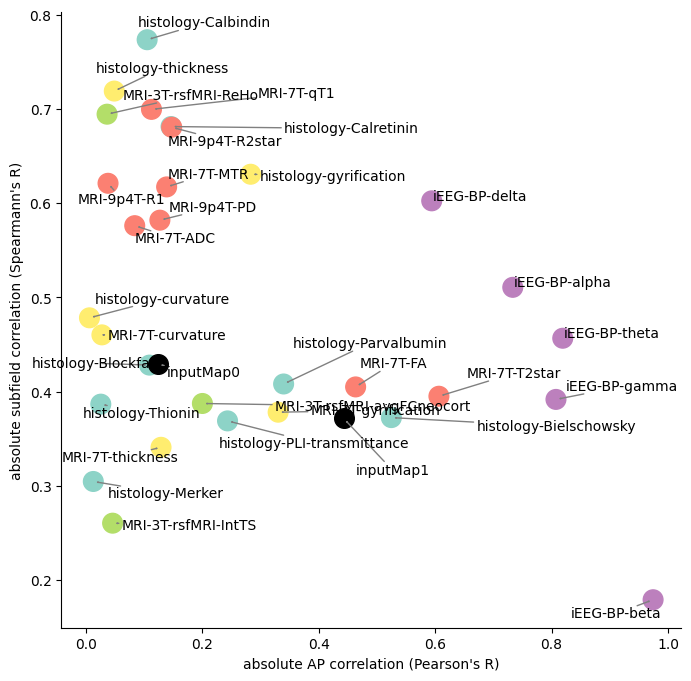

In [ ]:

# compute correlations with extant features (but only the top 3 to save time)
topFeatures = np.ones((nT,n_topComparison), dtype='object')
topR = np.ones((nT,n_topComparison))*np.nan
topP = np.ones((nT,n_topComparison))*np.nan
if n_topComparison >0:
    p = np.zeros((nT,len(contextHM['features'])))
    R = np.zeros((nT,len(contextHM['features'])))
    for t in range(nT):
        for j in range(len(contextHM['features'])):
            R[t,j],p[t,j] = pearsonr(taskMapsresamp[:,t],contextHM['featureData'][:,j])
    # get ordering of the closest n_topComparison neighbours and then run spin test
    for t in range(nT):
        order = np.argsort(np.abs(R[t,:]))[::-1]
        for c in range(n_topComparison):
            topFeatures[t,c] = contextHM['features'][order[c]]
            topR[t,c] = R[t,order[c]]
            metricnull = np.zeros((nperm))
            for d in range(nperm):
                metricnull[d] = pearsonr(contextHM['featureData'][:,order[c]], permutedTasks[:,t,d])[0]
            topP[t,c] = np.nanmean(np.abs(metricnull) >= np.abs(topR[t,c]))

# generate dict of results
context2D = {"Input map": taskNames, 
    "Subfields (R)": SubsR, 
    "Subfields (p corrected)": Subsp, 
    "A-P gradinet (R)": APR,
    "A-P gradinet (p corrected)": APp}
for c in range(n_topComparison):
    context2D[str(c) +"th most correlated"] = topFeatures[:,c]
    context2D[str(c) +"th (R)"] = topR[:,c]
    context2D[str(c) +"th (p corrected)"] = topP[:,c]

if plotTable:
    print(tabulate(context2D,headers="keys"))

fig, ax = plt.subplots(figsize=(8,8))
if plot2D:
    ax.spines[['right', 'top']].set_visible(False)
    ax.scatter(contextHM['axiscorrAPPD'][0],contextHM['subfieldsmaxcorr'],c=contextHM['colors'],cmap='Set3',s=200)
    plt.ylabel("absolute subfield correlation (Spearmann's R)")
    plt.xlabel("absolute AP correlation (Pearson's R)")
    texts = [ax.text(contextHM['axiscorrAPPD'][0,f], contextHM['subfieldsmaxcorr'][f], feature, ha='left', va='center') for f,feature in enumerate(contextHM['features'])]
    ax.scatter(np.abs(APR),np.abs(SubsR),color='k',s=200)
    for t in range(nT):
        texts.append(ax.text(np.abs(APR[t]), np.abs(SubsR[t]), taskNames[t], ha='left', va='center'))
    adjust_text(texts, expand=(1,2), arrowprops=dict(arrowstyle='->', color='gray'));
        
context2D, ax


({'Input map': ['inputMap0', 'inputMap1'],
  'Subfields (R)': array([ 0.42891768, -0.37146603]),
  'Subfields (p corrected)': array([0.006, 0.073]),
  'A-P gradinet (R)': array([-0.12392809,  0.44309376]),
  'A-P gradinet (p corrected)': array([0.891, 0.58 ]),
  '0th most correlated': array(['histology-Blockface', 'histology-Bielschowsky'], dtype=object),
  '0th (R)': array([0.98620398, 0.94607274]),
  '0th (p corrected)': array([0., 0.]),
  '1th most correlated': array(['MRI-7T-thickness', 'MRI-9p4T-R2star'], dtype=object),
  '1th (R)': array([0.50900733, 0.53471159]),
  '1th (p corrected)': array([0., 0.]),
  '2th most correlated': array(['MRI-9p4T-PD', 'MRI-9p4T-PD'], dtype=object),
  '2th (R)': array([ 0.50521656, -0.49881801]),
  '2th (p corrected)': array([0.005, 0.007])},
 <Axes: xlabel="absolute AP correlation (Pearson's R)", ylabel="absolute subfield correlation (Spearmann's R)">)

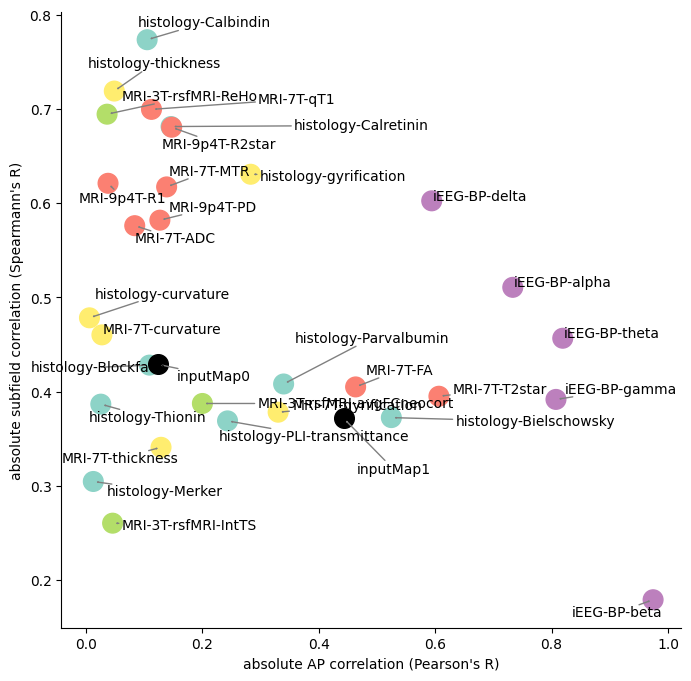

In [13]:

# compute correlations with extant features (but only the top 3 to save time)
topFeatures = np.ones((nT,n_topComparison), dtype='object')
topR = np.ones((nT,n_topComparison))*np.nan
topP = np.ones((nT,n_topComparison))*np.nan
if n_topComparison >0:
    p = np.zeros((nT,len(contextHM['features'])))
    R = np.zeros((nT,len(contextHM['features'])))
    for t in range(nT):
        for j in range(len(contextHM['features'])):
            R[t,j],p[t,j] = pearsonr(taskMapsresamp[:,t],contextHM['featureData'][:,j])
    # get ordering of the closest n_topComparison neighbours and then run spin test
    for t in range(nT):
        order = np.argsort(np.abs(R[t,:]))[::-1]
        for c in range(n_topComparison):
            topFeatures[t,c] = contextHM['features'][order[c]]
            topR[t,c] = R[t,order[c]]
            metricnull = np.zeros((nperm))
            for d in range(nperm):
                metricnull[d] = pearsonr(contextHM['featureData'][:,order[c]], permutedTasks[:,t,d])[0]
            topP[t,c] = np.nanmean(np.abs(metricnull) >= np.abs(topR[t,c]))

# generate dict of results
context2D = {"Input map": taskNames, 
    "Subfields (R)": SubsR, 
    "Subfields (p corrected)": Subsp, 
    "A-P gradinet (R)": APR,
    "A-P gradinet (p corrected)": APp}
for c in range(n_topComparison):
    context2D[str(c) +"th most correlated"] = topFeatures[:,c]
    context2D[str(c) +"th (R)"] = topR[:,c]
    context2D[str(c) +"th (p corrected)"] = topP[:,c]

if plotTable:
    print(tabulate(context2D,headers="keys"))

fig, ax = plt.subplots(figsize=(8,8))
if plot2D:
    ax.spines[['right', 'top']].set_visible(False)
    ax.scatter(contextHM['axiscorrAPPD'][0],contextHM['subfieldsmaxcorr'],c=contextHM['colors'],cmap='Set3',s=200)
    plt.ylabel("absolute subfield correlation (Spearmann's R)")
    plt.xlabel("absolute AP correlation (Pearson's R)")
    texts = [ax.text(contextHM['axiscorrAPPD'][0,f], contextHM['subfieldsmaxcorr'][f], feature, ha='left', va='center') for f,feature in enumerate(contextHM['features'])]
    ax.scatter(np.abs(APR),np.abs(SubsR),color='k',s=200)
    for t in range(nT):
        texts.append(ax.text(np.abs(APR[t]), np.abs(SubsR[t]), taskNames[t], ha='left', va='center'))
    adjust_text(texts, expand=(1,2), arrowprops=dict(arrowstyle='->', color='gray'));
        
context2D, ax


({'Input map': ['inputMap0', 'inputMap1'],
  'Subfields (R)': array([ 0.42891768, -0.37146603]),
  'Subfields (p corrected)': array([0.006, 0.073]),
  'A-P gradinet (R)': array([-0.12392809,  0.44309376]),
  'A-P gradinet (p corrected)': array([0.891, 0.58 ]),
  '0th most correlated': array(['histology-Blockface', 'histology-Bielschowsky'], dtype=object),
  '0th (R)': array([0.9863398 , 0.94620303]),
  '0th (p corrected)': array([0., 0.]),
  '1th most correlated': array(['MRI-7T-thickness', 'MRI-9p4T-R2star'], dtype=object),
  '1th (R)': array([0.50907743, 0.53478523]),
  '1th (p corrected)': array([0., 0.]),
  '2th most correlated': array(['MRI-9p4T-PD', 'MRI-9p4T-PD'], dtype=object),
  '2th (R)': array([ 0.50528614, -0.49888671]),
  '2th (p corrected)': array([0.005, 0.007])},
 <Axes: xlabel="absolute AP correlation (Pearson's R)", ylabel="absolute subfield correlation (Spearmann's R)">)

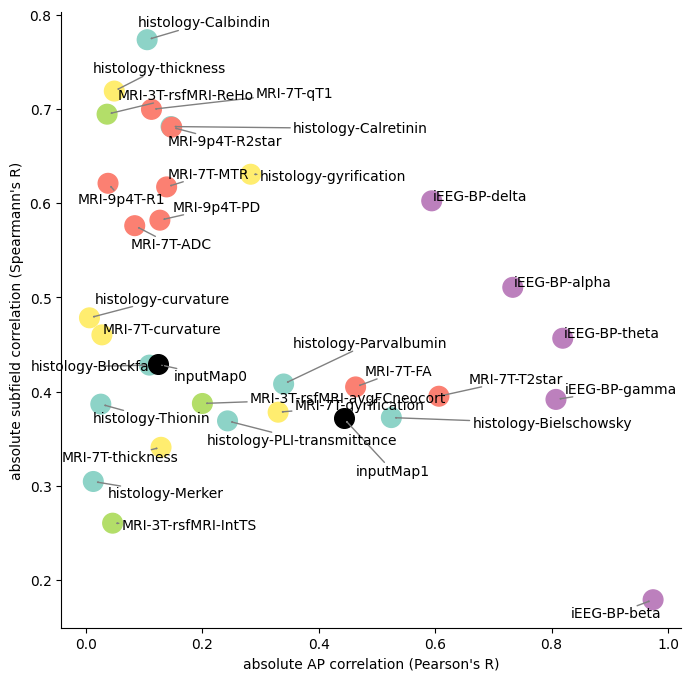

In [ ]:
# Define vectorized Pearson correlation function
def compute_pearson_correlations(x, Y):
    # x: shape (nV,)
    # Y: shape (nV, n_features or n_perm)
    x_mean = np.mean(x)
    x_std = np.std(x)
    if x_std == 0:
        return np.full(Y.shape[1], np.nan)
    x_z = (x - x_mean) / x_std

    Y_mean = np.mean(Y, axis=0)
    Y_std = np.std(Y, axis=0)
    valid = Y_std != 0
    correlations = np.full(Y.shape[1], np.nan)
    if np.any(valid):
        Y_z = np.zeros_like(Y)
        Y_z[:, valid] = (Y[:, valid] - Y_mean[valid]) / Y_std[valid]
        correlations[valid] = np.dot(x_z, Y_z[:, valid]) / (len(x_z) - 1)
    return correlations

# Define vectorized correlation functions with constant array checks
def compute_pearson_correlations(x, Y):
    x_mean = np.mean(x)
    x_std = np.std(x)
    if x_std == 0:
        return np.full(Y.shape[1], np.nan)
    x_z = (x - x_mean) / x_std

    Y_mean = np.mean(Y, axis=0)
    Y_std = np.std(Y, axis=0)
    valid = Y_std != 0
    correlations = np.full(Y.shape[1], np.nan)
    if np.any(valid):
        Y_z = np.zeros_like(Y)
        Y_z[:, valid] = (Y[:, valid] - Y_mean[valid]) / Y_std[valid]
        correlations[valid] = np.dot(x_z, Y_z[:, valid]) / (len(x_z) - 1)
    return correlations


# Initialize arrays for results
topFeatures = np.empty((nT, n_topComparison), dtype='object')
topR = np.full((nT, n_topComparison), np.nan)
topP = np.full((nT, n_topComparison), np.nan)

if n_topComparison > 0:
    R = np.zeros((nT,len(contextHM['features'])))
    # Vectorized computation of correlations between task maps and features
    for t in range(nT):
        x_task = taskMapsresamp[:, t]
        Y_features = contextHM['featureData']  # Shape: (nV, n_features)
        R_t = compute_pearson_correlations(x_task, Y_features)
        R[t, :] = R_t

    # Identify top correlated features and perform permutation tests
    for t in range(nT):
        # Get indices of top correlated features
        order = np.argsort(np.abs(R[t, :]))[::-1]
        for c in range(n_topComparison):
            idx = order[c]
            topFeatures[t, c] = contextHM['features'][idx]
            topR[t, c] = R[t, idx]

            # Prepare data for permutation test
            x_feature = contextHM['featureData'][:, idx]
            Y_permuted = permutedTasks[:, t, :]  # Shape: (nV, n_perm)

            # Compute correlations between feature and permuted task maps
            metricnull = compute_pearson_correlations(x_feature, Y_permuted)

            # Compute p-value
            if np.isnan(topR[t, c]):
                topP[t, c] = np.nan
            else:
                topP[t, c] = np.nanmean(np.abs(metricnull) >= np.abs(topR[t, c]))


# generate dict of results
context2D = {"Input map": taskNames, 
    "Subfields (R)": SubsR, 
    "Subfields (p corrected)": Subsp, 
    "A-P gradinet (R)": APR,
    "A-P gradinet (p corrected)": APp}
for c in range(n_topComparison):
    context2D[str(c) +"th most correlated"] = topFeatures[:,c]
    context2D[str(c) +"th (R)"] = topR[:,c]
    context2D[str(c) +"th (p corrected)"] = topP[:,c]

if plotTable:
    print(tabulate(context2D,headers="keys"))

fig, ax = plt.subplots(figsize=(8,8))
if plot2D:
    ax.spines[['right', 'top']].set_visible(False)
    ax.scatter(contextHM['axiscorrAPPD'][0],contextHM['subfieldsmaxcorr'],c=contextHM['colors'],cmap='Set3',s=200)
    plt.ylabel("absolute subfield correlation (Spearmann's R)")
    plt.xlabel("absolute AP correlation (Pearson's R)")
    texts = [ax.text(contextHM['axiscorrAPPD'][0,f], contextHM['subfieldsmaxcorr'][f], feature, ha='left', va='center') for f,feature in enumerate(contextHM['features'])]
    ax.scatter(np.abs(APR),np.abs(SubsR),color='k',s=200)
    for t in range(nT):
        texts.append(ax.text(np.abs(APR[t]), np.abs(SubsR[t]), taskNames[t], ha='left', va='center'))
    adjust_text(texts, expand=(1,2), arrowprops=dict(arrowstyle='->', color='gray'));
        
context2D, ax

